# Project 1

---

## Environment Setup

In [81]:
# Import libraries and dependencies
import numpy as np
import pandas as pd
import os
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import alpaca_trade_api as tradeapi
import requests
import hvplot.pandas
import plotly.express as px
from datetime import datetime
import backtrader as bt
import seaborn as sns

In [82]:
%matplotlib inline

In [83]:
# Initialize the Panel Extensions (for Plotly)
import panel as pn
from panel.interact import interact
from panel import widgets
pn.extension("plotly")

In [84]:
# Set the random seed for resutls reproducibility
np.random.seed(3)

---

In this activity, We will use the Alpaca API to grab historical data for the stocks

In [85]:
# Load .env enviroment variables
from dotenv import load_dotenv
load_dotenv()

# Set Alpaca API key and secret
alpaca_api_key = os.getenv("ALPACA_API_KEY")
alpaca_secret_key = os.getenv("ALPACA_SECRET_KEY")
fm_api_key=os.getenv("FM_API_KEY")

# Create the Alpaca API object
api = tradeapi.REST(
    alpaca_api_key,
    alpaca_secret_key,
    api_version="v2")

# Data Collection

In this step, we will use the Alpaca api to fetch closing prices for the stocks. Save the results as a pandas DataFrame

In [86]:
# Subset your tickers, then pull returns data:
# Set the ticker
ticker = ["RY","WMT","AMZN","SPY"]

# Set timeframe to '1D'
timeframe = "1D"

# Set start and end datetimes.
start_date = pd.Timestamp('2008-01-01', tz='America/New_York').isoformat()
end_date = pd.Timestamp('2020-06-30', tz='America/New_York').isoformat()

# Get historical data for RY, ENB, AMZN and SPY
df = api.get_barset(
    ticker,
    timeframe,
    limit=None,
    start=start_date,
    end=end_date,
    after=None,
    until=None,
).df

# Drop unnecessary columns
df = df.drop(
    columns=['open', 'high', 'low', 'volume'],
    level=1
)

In [87]:
# Display sample data

df.tail()

AMZN     RY     SPY     WMT
                             close  close   close   close
2020-06-24 00:00:00-04:00  2733.49  67.28  304.12  120.35
2020-06-25 00:00:00-04:00  2756.16  68.30  307.31  119.63
2020-06-26 00:00:00-04:00  2692.87  66.70  300.01  118.31
2020-06-29 00:00:00-04:00  2681.52  67.45  304.43  119.09
2020-06-30 00:00:00-04:00  2756.09  67.80  308.57  119.66

# Data Cleanup

In this step, We will cleanup the dataframe if necessary 

In [88]:
# Dataframe describe to identify any anomaly

df.describe()

AMZN           RY          SPY          WMT
             close        close        close        close
count  3146.000000  3145.000000  3146.000000  3146.000000
mean    639.923069    60.984543   186.261090    73.120223
std     646.922874    12.694951    66.398896    19.571854
min      35.040000    20.620000    68.070000    45.640000
25%     177.509000    52.570000   129.322500    55.512500
50%     321.936250    60.750000   186.320000    71.840000
75%     948.820000    71.700000   239.410000    80.946250
max    2764.420000    86.750000   338.310000   132.280000

In [89]:
# Determine whether there are any null values 
df.dropna(inplace=True)
df.isna().sum()

AMZN  close    0
RY    close    0
SPY   close    0
WMT   close    0
dtype: int64

In [90]:
# Slicing the dataframe till 2019-12-31
# This dataframe will be used for monte-carlo simulation for the next 6 month 

data_monte_carlo_df = df.loc["2008-01-02 00:00:00-05:00":"2019-12-31 00:00:00-05:00"]
data_monte_carlo_df.tail()

AMZN     RY     SPY     WMT
                             close  close   close   close
2019-12-24 00:00:00-05:00  1789.63  78.63  321.26  119.52
2019-12-26 00:00:00-05:00  1869.02  78.65  322.91  119.55
2019-12-27 00:00:00-05:00  1869.26  79.08  322.86  119.57
2019-12-30 00:00:00-05:00  1847.18  79.01  321.10  119.42
2019-12-31 00:00:00-05:00  1847.64  79.20  321.89  118.79

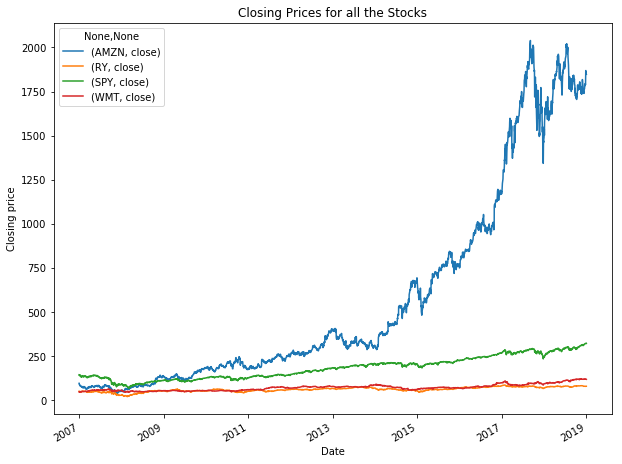

In [91]:
# PLot the close prices for all the stocks 
# PLot the close prices for all the stocks 
data_monte_carlo_df.plot(
    title="Closing Prices for all the Stocks",
    figsize=(10,8)
)
plt.xlabel('Date')
plt.ylabel('Closing price')
plt.show()

---

## Monte Carlo Simulation and relationship among stocks

In this step, we will run Monte Carlo Simulations for the stocks. 

Calculate the following 

1. Volatility

2. Beta

3. Sharpe Ratio

Monte Carlo steps: 

1. Calculate the daily returns of all the stocks.

2. Calculate volatility for all the stocks.

3. Find the last day's closing price for both the stocks and save those as variables

4. Run a Monte Carlo Simulation of at least `500` iterations and generate `6` months closing prices


In [92]:
# Calculate the daily roi for the stocks
daily_returns = (
    data_monte_carlo_df.pct_change()
    .dropna()
)

# Display sample data
daily_returns.head()

AMZN        RY       SPY       WMT
                              close     close     close     close
2008-01-03 00:00:00-05:00 -0.010706 -0.006134 -0.000623 -0.010874
2008-01-04 00:00:00-05:00 -0.067661 -0.019311 -0.024436 -0.016167
2008-01-07 00:00:00-05:00  0.001127 -0.007714  0.003761  0.020596
2008-01-08 00:00:00-05:00 -0.010356 -0.004092 -0.018733 -0.014384
2008-01-09 00:00:00-05:00 -0.032188  0.004108  0.014192  0.022217

In [93]:
# Compute daily volatility for avg return 

avg_daily_return_ry = daily_returns.mean()["RY"]["close"]
print (f"Avg daily return of RY : {avg_daily_return_ry}")

avg_daily_return_amzn = daily_returns.mean()["AMZN"]["close"]
print (f"Avg daily return of AMZN : {avg_daily_return_amzn}")

avg_daily_return_wmt = daily_returns.mean()["WMT"]["close"]
print (f"Avg daily return of WMT : {avg_daily_return_wmt}")

avg_daily_return_spy = daily_returns.mean()["SPY"]["close"]
print (f"Avg daily return of SPY : {avg_daily_return_spy}")

Avg daily return of RY : 0.0002869173068136578
Avg daily return of AMZN : 0.0012499740915761473
Avg daily return of WMT : 0.00038337873936628464
Avg daily return of SPY : 0.00033902107600586285


In [94]:
# Compute daily volatility for all the stocks

std_dev_ry = daily_returns.std()["RY"]["close"]
print (f"Daily Std deviation of RY : {std_dev_ry}")

std_dev_amzn = daily_returns.std()["AMZN"]["close"]
print (f"Daily Std deviation of AMZN : {std_dev_amzn}")

std_dev_wmt = daily_returns.std()["WMT"]["close"]
print (f"Daily Std deviation of WMT : {std_dev_wmt}")

std_dev_spy = daily_returns.std()["SPY"]["close"]
print (f"Daily Std deviation of SPY : {std_dev_spy}")

Daily Std deviation of RY : 0.01663860076914243
Daily Std deviation of AMZN : 0.02341169973142913
Daily Std deviation of WMT : 0.012298720829995422
Daily Std deviation of SPY : 0.01214377777588778


In [95]:
# Save the last day's closing price
last_price_ry = data_monte_carlo_df["RY"]["close"][-1]
print (f"RY price as of 2019-12-31 : {last_price_ry}")

last_price_amzn = data_monte_carlo_df["AMZN"]["close"][-1]
print (f"AMZN price as of 2019-12-31 : {last_price_amzn}")

last_price_wmt = data_monte_carlo_df["WMT"]["close"][-1]
print (f"WMT price as of 2019-12-31 : {last_price_wmt}")

last_price_spy = data_monte_carlo_df["SPY"]["close"][-1]
print (f"SPY price as of 2019-12-31 : {last_price_spy}")

RY price as of 2019-12-31 : 79.2
AMZN price as of 2019-12-31 : 1847.64
WMT price as of 2019-12-31 : 118.79
SPY price as of 2019-12-31 : 321.89


## Comparing the historical volatility to current volatility during Covid 19

In [96]:
# Use the `std` function and multiply by the square root of the number of trading days in a year to get annualized volatility
hist_vol = daily_returns.std() * np.sqrt(252)
hist_vol.sort_values(inplace=True)
hist_vol

SPY   close    0.192776
WMT   close    0.195236
RY    close    0.264130
AMZN  close    0.371649
dtype: float64

In [97]:
# Closing price data during Covid 19
covid_period_df = df.loc["2020-01-01 00:00:00-04:00":"2020-06-30 00:00:00-04:00"]

# daily returns calculation duing Covid 19
daily_returns_covid = covid_period_df.pct_change()

# Volatitlity calculation during Covid 19
vol_covid = daily_returns_covid.std() * np.sqrt(252)
vol_covid.sort_values(inplace=True)
vol_covid

WMT   close    0.387295
AMZN  close    0.402705
SPY   close    0.460224
RY    close    0.542013
dtype: float64

In [98]:
vol_covid.to_frame()
hist_vol.to_frame()

0
SPY  close  0.192776
WMT  close  0.195236
RY   close  0.264130
AMZN close  0.371649

Text(0, 0.5, 'Volatilty')

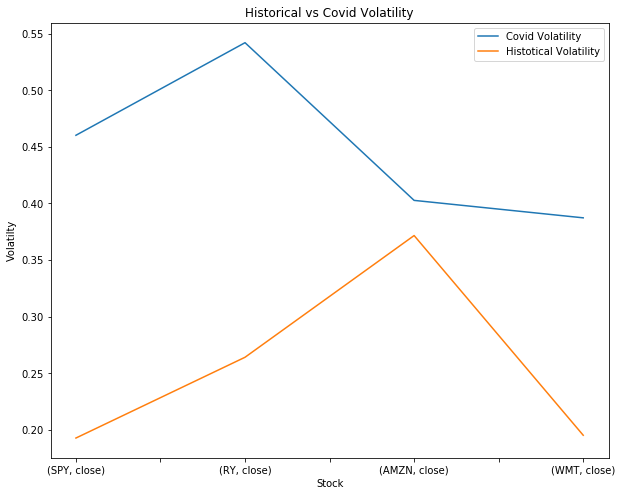

In [99]:
volatility_comp = pd.concat([vol_covid,hist_vol],axis='columns',join='inner')
volatility_comp.columns = ['Covid Volatility','Histotical Volatility']

volatility_comp.plot(figsize=(10,8),title='Historical vs Covid Volatility')
plt.xlabel('Stock')
plt.ylabel('Volatilty')

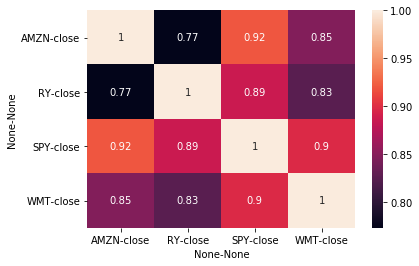

In [100]:
# Calculate the correlation between each stock
correlation = data_monte_carlo_df.corr()

# Plotting the Correlation amoung stocks
sns.heatmap(correlation,annot = True)

 ## Calculate Covariance of Selected Stock Returns vs. S&P Returns

In [101]:
# Calculate covariance of all daily returns of the stocks vs. S&P 500
AMZN_covariance = daily_returns['AMZN']['close'].cov(daily_returns['SPY']['close'])
RY_covariance = daily_returns['RY']['close'].cov(daily_returns['SPY']['close'])
WMT_covariance = daily_returns['WMT']['close'].cov(daily_returns['SPY']['close'])

# Calculate variance of  S&P 500
variance = daily_returns['SPY']['close'].var()

# Calculate beta of all daily returns of selected stocks
AMZN_beta = AMZN_covariance / variance
RY_beta = RY_covariance / variance
WMT_beta = WMT_covariance / variance

print(f"AMZN: {AMZN_beta} | RY: {RY_beta} | WMT: {WMT_beta}")

AMZN: 1.1396807730456282 | RY: 1.0142412830260041 | WMT: 0.520037840727599


In [102]:
# Calculate covariance of all daily returns of the stocks vs. S&P covid perid
AMZN_covariance_covid = daily_returns_covid['AMZN']['close'].cov(daily_returns_covid['SPY']['close'])
RY_covariance_covid = daily_returns_covid['RY']['close'].cov(daily_returns_covid['SPY']['close'])
WMT_covariance_covid = daily_returns_covid['WMT']['close'].cov(daily_returns_covid['SPY']['close'])

# Calculate variance of  S&P 500 - covid period
variance_covid = daily_returns_covid['SPY']['close'].var()
variance_covid

# Calculate beta of all daily returns of selected stocks
AMZN_beta_covid = AMZN_covariance_covid / variance_covid
RY_beta_covid = RY_covariance_covid / variance_covid
WMT_beta_covid = WMT_covariance_covid / variance_covid

print(f"AMZN: {AMZN_beta_covid} | RY: {RY_beta_covid} | WMT: {WMT_beta_covid}")

AMZN: 0.5909243365923369 | RY: 0.9965055988522178 | WMT: 0.5158337232415983


## Calculate 30-Day Rolling Betas of Selected Stock Returns vs. S&P Returns**

In [103]:
# Calculate 30-day rolling covariance of each stock vs. S&P 500 and plot the data
rolling_AMZN_covariance = daily_returns['AMZN']['close'].rolling(window=30).cov(daily_returns['SPY']['close'])
rolling_RY_covariance = daily_returns['RY']['close'].rolling(window=30).cov(daily_returns['SPY']['close'])
rolling_WMT_covariance = daily_returns['WMT']['close'].rolling(window=30).cov(daily_returns['SPY']['close'])

# Calculate 30-day rolling variance of S&P 500
rolling_variance = daily_returns['SPY']['close'].rolling(window=30).var()

# Calculate 30-day rolling beta of AMZN and plot the data
rolling_AMZN_beta = rolling_AMZN_covariance / rolling_variance
rolling_RY_beta = rolling_RY_covariance / rolling_variance
rolling_WMT_beta = rolling_WMT_covariance / rolling_variance

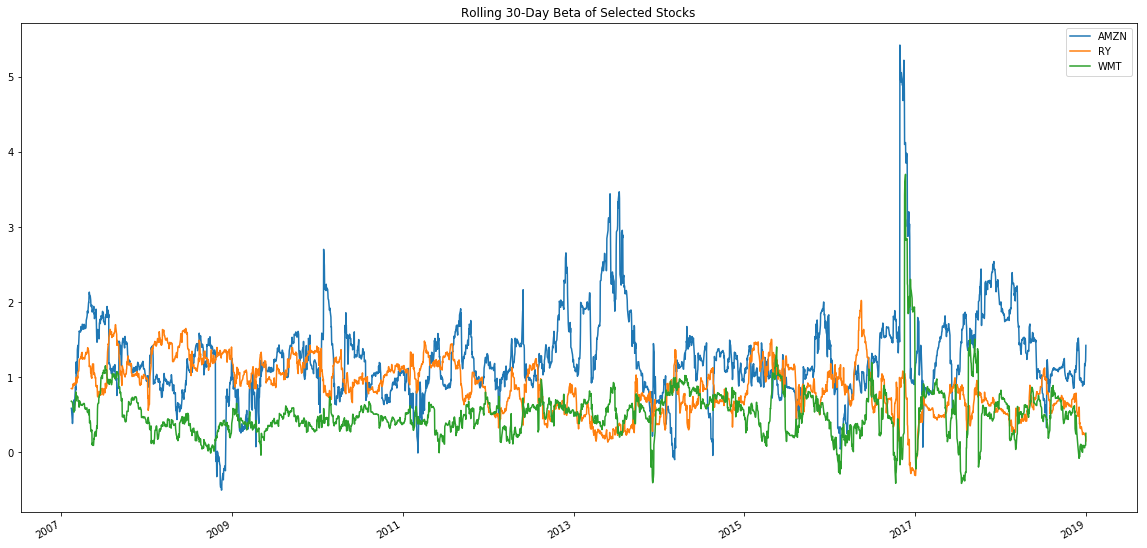

In [104]:
# Set the figure and plot the different datasets as multiple trends on the same figure
ax = rolling_AMZN_beta.plot(figsize=(20, 10), title='Rolling 30-Day Beta of Selected Stocks')
rolling_RY_beta.plot(ax=ax)
rolling_WMT_beta.plot(ax=ax)

# Set the legend of the figure
ax.legend(["AMZN", "RY", "WMT"])

## SHARPE RATIO

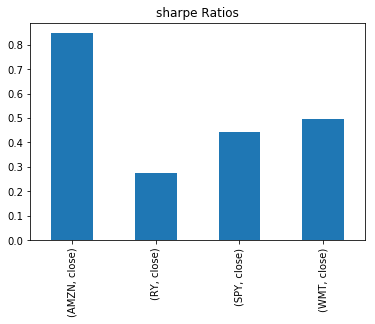

In [105]:
# Use the `mean` and `std` functions to calculate the annualized sharpe ratio
sharpe_ratios = (daily_returns.mean() * 252) / (daily_returns.std() * np.sqrt(252))
sharpe_ratios

#Plot the covid pre=covid graph
sharpe_ratios.plot(kind = "bar", title = "sharpe Ratios")

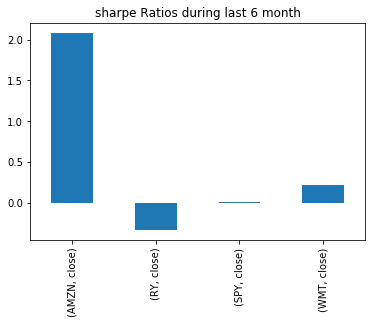

In [106]:
# Use the `mean` and `std` functions to calculate the sharpe ratio for the 6 month covid period Jan - June
sharpe_ratios_covid = (daily_returns_covid.mean() * 252) / (daily_returns_covid.std() * np.sqrt(252))

#Plot the covid period graph
sharpe_ratios_covid.plot(kind = "bar", title = "sharpe Ratios during last 6 month")

## Monte Carlo Simulation Run

In [107]:
# Run the Monte Carlo Simulation
# Run the simulation of projecting stock prices for the next 6 months

def monte_carlo_sim(stock_last_price,stock_avg_return,stock_std_dev):
    
    # Setup the Monte Carlo Parameters
    number_simulations = 500
    number_records = 126
    monte_carlo = pd.DataFrame()
    simulated_price_df = pd.DataFrame()

    for n in range(number_simulations):

        # Initialize the simulated prices list with the last closing price stock
        simulated_prices = [stock_last_price]
    
        # Simulate the returns for 126 days
        for i in range(number_records):
        
            # Calculate the simulated price using the last price within the list
            simulated_price = simulated_prices[-1] * (1 + np.random.normal(stock_avg_return, stock_std_dev))
        
            # Append the simulated price to the list
            simulated_prices.append(simulated_price)
    
        # Append a simulated prices of each simulation to DataFrame
        simulated_price_df["Prices"] = pd.Series(simulated_prices)
    
        # Calculate the daily returns of simulated prices
        simulated_daily_returns = simulated_price_df.pct_change()
    
        # Set the portfolio weights (40% AGG; 60% SPY)
        weights = [1]

        # Use the `dot` function with the weights to multiply weights with each column"s simulated daily returns
        portfolio_daily_returns = simulated_daily_returns.dot(weights)
    
        # Calculate the normalized, cumulative return series
        monte_carlo[n] = (1 + portfolio_daily_returns.fillna(0)).cumprod()
                
    return monte_carlo

In [108]:
# Check that the simulation ran successfully
ry_monte_carlo = monte_carlo_sim(last_price_ry, avg_daily_return_ry, std_dev_ry)

ry_monte_carlo.tail()

0         1         2         3         4         5         6    \
122  0.880236  1.347657  0.974002  0.973896  1.207069  1.011814  0.901692   
123  0.869455  1.372032  0.982657  1.003591  1.198845  0.998220  0.914457   
124  0.844474  1.376227  0.975866  0.990249  1.202178  1.017263  0.936267   
125  0.847888  1.415996  0.979904  0.995245  1.182589  1.002470  0.938521   
126  0.852181  1.360818  0.999633  0.988930  1.207799  0.986112  0.953668   

          7         8         9    ...       490       491       492  \
122  1.152698  0.958578  0.798124  ...  1.457387  1.327459  1.006312   
123  1.116404  0.919155  0.803382  ...  1.464193  1.320938  1.008717   
124  1.082544  0.930933  0.813086  ...  1.450185  1.303769  1.037802   
125  1.118103  0.915828  0.808719  ...  1.448573  1.337653  1.055082   
126  1.122355  0.905429  0.808176  ...  1.473258  1.319900  1.046068   

          493       494       495       496       497       498       499  
122  1.211474  1.129846  1.441332  1.591632  1.259943  1.158908  1.093769  
123  1.192169  1.132739  1.444086  1.556746  1.268142  1.160416  1.082387  
124  1.199724  1.150973  1.423956  1.556053  1.230281  1.177175  1.087765  
125  1.180134  1.137296  1.391202  1.560862  1.217914  1.191191  1.098441  
126  1.196626  1.111381  1.400881  1.572894  1.187385  1.193414  1.103109  

[5 rows x 500 columns]

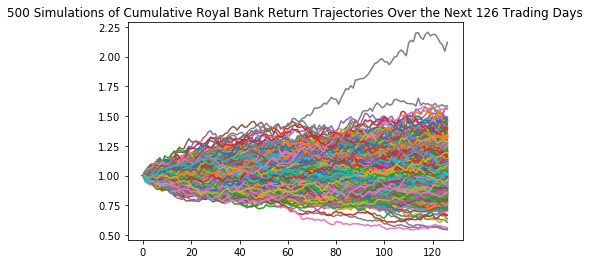

In [109]:
# Visualize the Simulation
plot_title = f"500 Simulations of Cumulative Royal Bank Return Trajectories Over the Next 126 Trading Days"
ry_monte_carlo.plot(legend=None, title=plot_title)

0.05    0.745757
0.95    1.397077
Name: 126, dtype: float64


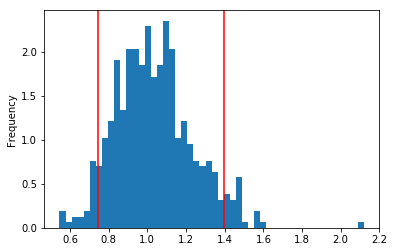

In [110]:
# Select the last row for the cumulative returns (cumulative returns at 30 years)
ry_end_cum_retun = ry_monte_carlo.iloc[-1, :]

# Display the 90% confidence interval for the ending returns
ry_confi_inte = ry_end_cum_retun.quantile(q=[0.05, 0.95])
print (ry_confi_inte)

# Visualize the distribution of the ending returns
plt.figure();
ry_end_cum_retun.plot(kind="hist", density=True, bins=50)
plt.axvline(ry_confi_inte.iloc[0], color="r")
plt.axvline(ry_confi_inte.iloc[1], color="r")

In [111]:
# Check that the simulation ran successfully
amzn_monte_carlo = monte_carlo_sim(last_price_amzn, avg_daily_return_amzn, std_dev_amzn)

amzn_monte_carlo.tail()

0         1         2         3         4         5         6    \
122  0.916458  1.960118  1.880983  1.109985  0.735805  1.093887  0.626437   
123  0.905811  1.891233  1.959046  1.121877  0.720461  1.097777  0.643433   
124  0.902937  1.948333  1.933709  1.161636  0.723683  1.085622  0.665583   
125  0.901033  1.927696  1.881316  1.162134  0.739262  1.079661  0.678295   
126  0.878220  1.905114  1.861210  1.144188  0.726609  1.069128  0.703195   

          7         8         9    ...       490       491       492  \
122  1.016285  1.404578  1.269580  ...  0.774483  1.054751  0.912296   
123  1.040924  1.431476  1.306455  ...  0.800753  1.051054  0.897181   
124  1.052768  1.453474  1.269412  ...  0.795225  1.095763  0.888437   
125  1.076010  1.429498  1.303601  ...  0.820015  1.130343  0.907455   
126  1.077584  1.474866  1.297382  ...  0.839823  1.092259  0.906335   

          493       494       495       496       497       498       499  
122  1.206514  0.876149  1.415840  1.362182  1.225504  0.825328  1.367012  
123  1.212175  0.910075  1.436529  1.349230  1.205251  0.823518  1.376833  
124  1.238063  0.902852  1.414765  1.293189  1.245839  0.842976  1.384043  
125  1.230428  0.890036  1.433745  1.342521  1.245557  0.856468  1.383259  
126  1.198257  0.910826  1.415095  1.328618  1.293604  0.863195  1.388043  

[5 rows x 500 columns]

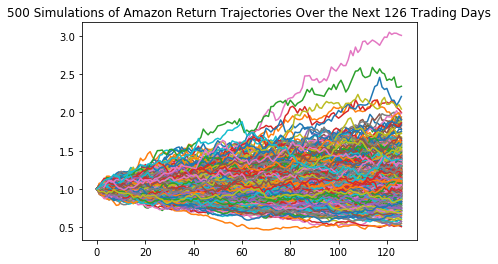

In [112]:
# Visualize the Simulation
plot_title = f"500 Simulations of Amazon Return Trajectories Over the Next 126 Trading Days"
amzn_monte_carlo.plot(legend=None, title=plot_title)

0.05    0.713485
0.95    1.672474
Name: 126, dtype: float64


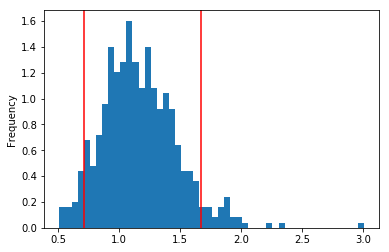

In [113]:
# Select the last row for the cumulative returns (cumulative returns at 30 years)
amzn_end_cum_retun = amzn_monte_carlo.iloc[-1, :]

# Display the 90% confidence interval for the ending returns
amzn_confi_inte = amzn_end_cum_retun.quantile(q=[0.05, 0.95])
print (amzn_confi_inte)

# Visualize the distribution of the ending returns
plt.figure();
amzn_end_cum_retun.plot(kind="hist", density=True, bins=50)
plt.axvline(amzn_confi_inte.iloc[0], color="r")
plt.axvline(amzn_confi_inte.iloc[1], color="r")

---

In [114]:
# Check that the simulation ran successfully
wmt_monte_carlo = monte_carlo_sim(last_price_wmt, avg_daily_return_wmt, std_dev_wmt)

wmt_monte_carlo.tail()

0         1         2         3         4         5         6    \
122  1.089198  1.095768  0.998876  1.034115  1.081085  1.020099  1.105202   
123  1.100152  1.070920  0.996745  1.028541  1.086744  1.018828  1.104265   
124  1.088750  1.061123  0.995331  1.048371  1.095887  1.009072  1.088072   
125  1.069856  1.045189  0.988999  1.037493  1.067533  1.022978  1.107250   
126  1.066151  1.033691  0.986855  1.032676  1.055140  1.020141  1.086543   

          7         8         9    ...       490       491       492  \
122  1.047004  1.048355  0.985423  ...  0.943456  1.116627  0.952421   
123  1.057002  1.034890  0.993439  ...  0.962749  1.128857  0.945049   
124  1.090746  1.025868  0.981128  ...  0.958661  1.140101  0.960537   
125  1.090170  1.046685  0.980160  ...  0.938868  1.132692  0.942510   
126  1.084658  1.055281  0.976665  ...  0.945421  1.145130  0.936255   

          493       494       495       496       497       498       499  
122  1.085831  1.137419  1.139444  1.188958  1.317709  1.078239  0.960727  
123  1.082203  1.115909  1.129228  1.184017  1.334998  1.086084  0.967096  
124  1.091404  1.106682  1.144953  1.189924  1.349248  1.073968  0.945590  
125  1.079767  1.121536  1.127999  1.196874  1.358841  1.081495  0.946183  
126  1.093343  1.121693  1.118558  1.217455  1.362352  1.065612  0.945110  

[5 rows x 500 columns]

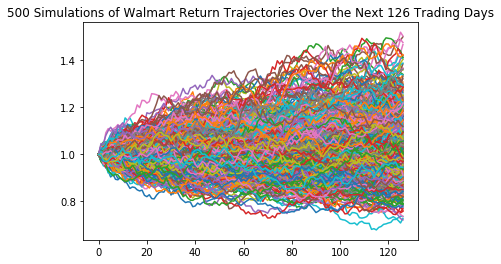

In [115]:
# Visualize the Simulation
plot_title = f"500 Simulations of Walmart Return Trajectories Over the Next 126 Trading Days"
wmt_monte_carlo.plot(legend=None, title=plot_title)

0.05    0.825706
0.95    1.294682
Name: 126, dtype: float64


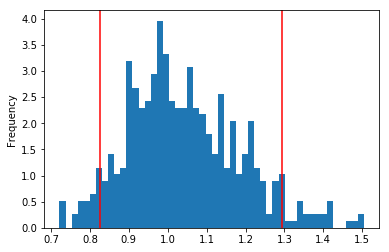

In [116]:
# Select the last row for the cumulative returns (cumulative returns at 30 years)
wmt_end_cum_retun = wmt_monte_carlo.iloc[-1, :]

# Display the 90% confidence interval for the ending returns
wmt_confi_inte = wmt_end_cum_retun.quantile(q=[0.05, 0.95])
print (wmt_confi_inte)

# Visualize the distribution of the ending returns
plt.figure();
wmt_end_cum_retun.plot(kind="hist", density=True, bins=50)
plt.axvline(wmt_confi_inte.iloc[0], color="r")
plt.axvline(wmt_confi_inte.iloc[1], color="r")

In [117]:
spy_monte_carlo = monte_carlo_sim(last_price_spy, avg_daily_return_spy, std_dev_spy)

spy_monte_carlo.tail()

0         1         2         3         4         5         6    \
122  0.882417  0.998497  1.057878  1.020313  1.203956  0.931983  0.937878   
123  0.859878  0.989676  1.054832  1.016557  1.181420  0.941215  0.930356   
124  0.852601  0.988858  1.094630  1.005386  1.195871  0.942725  0.931444   
125  0.842691  0.981133  1.109809  1.000813  1.214368  0.963648  0.921066   
126  0.850457  0.967850  1.114311  0.997279  1.217181  0.949793  0.911721   

          7         8         9    ...       490       491       492  \
122  0.984859  0.931171  1.245855  ...  1.131174  0.909093  1.104594   
123  0.967556  0.905947  1.240535  ...  1.162930  0.905384  1.081362   
124  0.964392  0.913549  1.256631  ...  1.169588  0.922497  1.082215   
125  0.977728  0.921299  1.242000  ...  1.181278  0.913799  1.078009   
126  0.982996  0.928774  1.232123  ...  1.208569  0.932223  1.078886   

          493       494       495       496       497       498       499  
122  1.245516  0.924363  0.953576  1.010148  1.133108  1.171638  1.000648  
123  1.219047  0.908395  0.974918  1.006314  1.135561  1.167101  0.982156  
124  1.201541  0.899918  0.982728  1.006218  1.150949  1.187074  0.980008  
125  1.209723  0.895936  0.985499  0.991430  1.178806  1.206169  0.991380  
126  1.210636  0.908168  0.965530  0.988867  1.191132  1.183116  0.989288  

[5 rows x 500 columns]

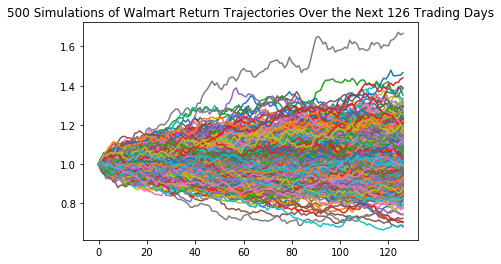

In [118]:
# Visualize the Simulation
plot_title = f"500 Simulations of Walmart Return Trajectories Over the Next 126 Trading Days"
spy_monte_carlo.plot(legend=None, title=plot_title)

0.05    0.841019
0.95    1.242379
Name: 126, dtype: float64


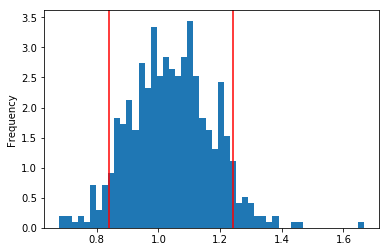

In [119]:
# Select the last row for the cumulative returns (cumulative returns at 30 years)
spy_end_cum_retun = spy_monte_carlo.iloc[-1, :]

# Display the 90% confidence interval for the ending returns
spy_confi_inte = spy_end_cum_retun.quantile(q=[0.05, 0.95])
print (spy_confi_inte)

# Visualize the distribution of the ending returns
plt.figure();
spy_end_cum_retun.plot(kind="hist", density=True, bins=50)
plt.axvline(spy_confi_inte.iloc[0], color="r")
plt.axvline(spy_confi_inte.iloc[1], color="r")

In [120]:
# Getting all the price at differnt point for comparison

price_comp_amzn_dict = {}

price_comp_amzn_dict['Stock'] = 'AMZN'
price_comp_amzn_dict['5th Percentile'] = (round(amzn_confi_inte.iloc[0]*last_price_amzn,2))
price_comp_amzn_dict['95th Percetile'] = (round(amzn_confi_inte.iloc[1]*last_price_amzn,2))
price_comp_amzn_dict['Actual Price'] = df['AMZN']['close'][-1]
price_comp_amzn_dict['Lowest Price'] = covid_period_df['AMZN']['close'].min()

In [121]:
# Getting all the price at differnt point for comparison

price_comp_wmt_dict = {}

price_comp_wmt_dict['Stock'] = 'WMT'
price_comp_wmt_dict['5th Percentile'] = (round(wmt_confi_inte.iloc[0]*last_price_wmt,2))
price_comp_wmt_dict['95th Percetile'] = (round(wmt_confi_inte.iloc[1]*last_price_wmt,2))
price_comp_wmt_dict['Actual Price'] = df['WMT']['close'][-1]
price_comp_wmt_dict['Lowest Price'] = covid_period_df['WMT']['close'].min()

In [122]:
# Getting all the price at differnt point for comparison

price_comp_ry_dict = {}

price_comp_ry_dict['Stock'] = 'RY'
price_comp_ry_dict['5th Percentile'] = (round(ry_confi_inte.iloc[0]*last_price_ry,2))
price_comp_ry_dict['95th Percetile'] = (round(ry_confi_inte.iloc[1]*last_price_ry,2))
price_comp_ry_dict['Actual Price'] = df['RY']['close'][-1]
price_comp_ry_dict['Lowest Price'] = covid_period_df['RY']['close'].min()

In [123]:
# Merging into one dataframe

price_comp_df = pd.DataFrame()
price_comp_df = price_comp_df.append(price_comp_amzn_dict, True)
price_comp_df = price_comp_df.append(price_comp_ry_dict, True)
price_comp_df = price_comp_df.append(price_comp_wmt_dict, True)

In [124]:
# Setting the index 

price_comp_df.set_index('Stock',inplace=True)
price_comp_df

5th Percentile  95th Percetile  Actual Price  Lowest Price
Stock                                                            
AMZN          1318.26         3090.13       2756.09       1676.21
RY              59.06          110.65         67.80         49.57
WMT             98.09          153.80        119.66        104.05

In [125]:
# Plotting the price data comparison for Monte Carlo

monte_carlo_plot = price_comp_df.hvplot(
    kind='bar',
    x="Stock",
    y=('5th Percentile','95th Percetile','Actual Price','Lowest Price'),
    groupby='Stock',
    xlabel='Stock',
    ylabel ='Stock Price',
    width=700, 
    height=400,
)
monte_carlo_plot

:DynamicMap   [Stock]
   :Bars   [Stock,Variable]   (value)

-------

## Fundamental Analysis

Dashboard contains data from each company's financial statements. The dashboard will contain:

* Balance Sheet Bar Chart (Total Assests, Total Liabilities, Total Equity)
* Income Statement Bar Chart (Net Income, Operating, Total Revenue)
* Cash Flow Statement Bar Chart (Operations, Investing, Financing)

The dashboard will also contain the following financial ratios:
* P/E Ratio
* Earnings per Share
* Return on Equity

Lastly, the dashboard will show the last four quarters of financial statements from the select companies for:
* Net Income
* EPS
* ROE

Annual Reporting Periods:
* Amazon: Dec 31
* Walmart: Jan 31
* RBC: Oct 31

In [126]:
stock_list = ['RY','WMT','AMZN']

In [127]:
def get_fin_statement(stock_ticker):
    balance_sheet_url = f"https://financialmodelingprep.com/api/v3/financials/balance-sheet-statement/{stock_ticker}?apikey={fm_api_key}"
    balance_sheet_req = requests.get(url = balance_sheet_url)
    balance_sheet_data = balance_sheet_req.json()

    income_url = f"https://financialmodelingprep.com/api/v3/financials/income-statement/{stock_ticker}?apikey={fm_api_key}"
    income_state_req = requests.get(url = income_url)
    income_state_data = income_state_req.json()

    cash_flow_url = f"https://financialmodelingprep.com/api/v3/financials/cash-flow-statement/{stock_ticker}?apikey={fm_api_key}"
    cash_flow_req = requests.get(url = cash_flow_url)
    cash_flow_data = cash_flow_req.json()
    
    ratios_url = f'https://financialmodelingprep.com/api/v3/ratios/{stock_ticker}?apikey={fm_api_key}'
    ratios_req = requests.get(url = ratios_url)
    ratios_data = ratios_req.json() 
      
    return balance_sheet_data, income_state_data, cash_flow_data, ratios_data

In [128]:
ry_balance_sheet_data, ry_income_state_data, ry_cash_flow_data,ry_ratio = get_fin_statement("RY")
amzn_balance_sheet_data, amzn_income_state_data, amzn_cash_flow_data, amzn_ratio = get_fin_statement("AMZN")
wmt_balance_sheet_data, wmt_income_state_data, wmt_cash_flow_data, wmt_ratio = get_fin_statement("WMT")

In [129]:
def add_fiscal(df, df_type, ticker):
    '''
    Add Fiscal Years to all financial statement and financial ratio dataframes.
    
    '''
    
    df = df.sort_values(by='date', ascending=True)
    
    # if the df is from the financial statements. Use these Fiscal Dates
    if df_type == 'statement':
        
        if ticker == 'WMT' or ticker == 'AMZN':
            df['Fiscal Year'] = [2009+i for i in range(11)]
            df = df.set_index('Fiscal Year')
            return df

        elif ticker == 'RY':
            df['Fiscal Year'] = [2009+i for i in range(10)]
            df = df.set_index('Fiscal Year')
            return df
    
    # if the df is from the ratios. Use these Fiscal Dates.
    elif df_type == 'ratio':
        if ticker == 'WMT' or ticker == 'AMZN':
            df['Fiscal Year'] = [2001+i for i in range(19)]
            df = df.set_index('Fiscal Year')
            return df
            
        if ticker == 'RY':
            df['Fiscal Year'] = [2009+i for i in range(10)]
            df = df.set_index('Fiscal Year')
            return df
    
    else:
        return

In [130]:
def clean_ratios(data,ticker):
    '''
    Cleans the json file from the API and returns financial ratios.
    '''
    # ratios to be pulled from json
    ratios = ['returnOnEquity','dividendPayoutRatio','priceEarningsRatio']

    ratio_dict = {}
    df = pd.DataFrame()
    
    # pulls dates and ratios and adds them to a df
    for annual_report in data:
        ratio_dict['date'] = annual_report['date']
        
        for ratio in ratios:  
            ratio_dict[ratio] = annual_report[ratio]
            
        df = df.append(ratio_dict,True)
    
    df = df.rename(columns = {'returnOnEquity':'Return on Equity',
                    'dividendPayoutRatio':'Dividend Payout Ratio',
                    'priceEarningsRatio':'Price Earnings Ratio'})
    
    df = df.sort_values(by='date', ascending=True)
    
    df = add_fiscal(df,'ratio',ticker)
    
    df = df.drop('date',1)
    
    df = df.astype('float')
    
    # limits all datasets to the same range
    df = df.loc[2008:2018]
        
    return df

In [131]:
def clean_fs_data(data,statement_type,ticker):
    '''
    Cleans the json file from the API and returns one of the three financial statements.
    
    statement_type should be 'cf' 'is' or 'bs' for financial statements. 
    '''
    
    # components to be pulled for each statement
    cash_flow = ['Operating Cash Flow', 'Investing Cash flow', 'Financing Cash Flow']
    income_st = ['Net Income', 'Operating Income','Revenue']
    balance_sh = ['Total assets','Total liabilities','Total shareholders equity']
    
    # branching to determine the type of financial statement that was given.
    if statement_type == 'cf':
        statement = cash_flow
        
    elif statement_type == 'is':
        statement = income_st
        
    elif statement_type == 'bs':
        statement = balance_sh
        
    else:
        return 'invalid entry'

    # pulling data from json.
    df = pd.DataFrame()
    data_dict = {}

    for financial_statement in data["financials"]:
        data_dict['date'] = financial_statement['date']
        
        for item in statement:
            data_dict[item] = financial_statement[item]

        df = df.append(data_dict, True)
    
    df = df.sort_values(by='date', ascending=True)
    
    df = add_fiscal(df,'statement',ticker)
    
    df = df.drop('date',1)
    
    df = df.astype('float')
    
    df = df.loc[2008:2018]

    return df

In [132]:
# RY Data clean
RY_CF = clean_fs_data(ry_cash_flow_data,'cf','RY')
RY_BS = clean_fs_data(ry_balance_sheet_data,'bs','RY')
RY_IS = clean_fs_data(ry_income_state_data,'is','RY')
RY_Rat = clean_ratios(ry_ratio,'RY')

# AMZN Data clean
AMZN_CF = clean_fs_data(amzn_cash_flow_data,'cf','AMZN')
AMZN_BS = clean_fs_data(amzn_balance_sheet_data,'bs','AMZN')
AMZN_IS = clean_fs_data(amzn_income_state_data, 'is','AMZN')
AMZN_Rat = clean_ratios(amzn_ratio,'AMZN')

# WMT Data clean
WMT_CF = clean_fs_data(wmt_cash_flow_data,'cf','WMT')
WMT_BS = clean_fs_data(wmt_balance_sheet_data,'bs','WMT')
WMT_IS = clean_fs_data(wmt_income_state_data,'is','WMT')
WMT_Rat = clean_ratios(wmt_ratio,'WMT')

In [133]:
def ratio_graph(df):
    df = df.reset_index()
    
    df = pd.melt(df,id_vars=['Fiscal Year'], var_name='Ratio', value_name='values')
    
    return df.hvplot(x='Fiscal Year',
                      y='values',
                      xticks=list(set(df['Fiscal Year'])),
                      groupby='Ratio',
                     title= f'Financial Ratios'
                    )

def statement_graphs(df,title):
    fig = px.bar(df,
                 x=df.index,
                 y=df.columns,
                 barmode='group',
                 title=f'{title}'
                )
    
    return fig

In [134]:
# import quarterly data
quarterly_statement = pd.read_csv('Quarterly_Data.csv')
quarterly_statement['Value'] = quarterly_statement['Value'].astype('float')

In [135]:
def select_ticker_data(df,ticker,metric):
    '''
    Extracts the ROE, EPS, or Net Income from the dataframe by ticker
    '''
    quarterly = df[(df['Ticker'] == f'{ticker}') &(df['Indicator'] == f'{metric}')]
    quarterly.set_index('Quarter',inplace=True)
    quarterly_series = quarterly['Value']

    return quarterly_series

def plot_quarterly_results(series, title, ylabel, ind_type):
    
    if ind_type == 'Net Income':
        color = 'green'
    elif ind_type == 'ROE':
        color = 'orange'
    elif ind_type == 'EPS':
        color ='blue'
    else:
        return 'Error'
    
    return series.hvplot.bar(title=title,
                             xlabel='Quarters', 
                             ylabel=ylabel,
                             height=250, 
                             width=400,
                             color=color,
                            shared_axes=False
                            )

In [136]:
# RY Datasets
RY_NI = plot_quarterly_results(select_ticker_data(quarterly_statement,'RY','Net Income'),
                         'RBC: Net Income',
                         'Values',
                         'Net Income')

RY_ROE = plot_quarterly_results(select_ticker_data(quarterly_statement,'RY','ROE'),
                         'RBC: Return on Equity',
                         'Percentage',
                         'ROE'
                        )

RY_EPS = plot_quarterly_results(select_ticker_data(quarterly_statement,'RY','Diluted EPS'),
                        'RBC: Diluted Earnings per Share',
                        'Values',
                        'EPS')

# AMZN Dataset
AMZN_NI = plot_quarterly_results(select_ticker_data(quarterly_statement,'AMZN','Net Income'),
                         'Amazon: Net Income',
                         'Values',
                         'Net Income')

AMZN_ROE = plot_quarterly_results(select_ticker_data(quarterly_statement,'AMZN','ROE'),
                         'Amazon: Return on Equity',
                         'Percentage',
                         'ROE'
                        )

AMZN_EPS = plot_quarterly_results(select_ticker_data(quarterly_statement,'AMZN','Diluted EPS'),
                        'Amazon: Diluted Earnings per Share',
                        'Values',
                        'EPS')

# WMT Dataset
WMT_NI = plot_quarterly_results(select_ticker_data(quarterly_statement,'WMT','Net Income'),
                         'Walmart: Net Income',
                         'Values',
                         'Net Income')

WMT_ROE = plot_quarterly_results(select_ticker_data(quarterly_statement,'WMT','ROE'),
                         'Walmart: Return on Equity',
                         'Percentage',
                         'ROE'
                        )

WMT_EPS = plot_quarterly_results(select_ticker_data(quarterly_statement,'WMT','Diluted EPS'),
                        'Walmart: Diluted Earnings per Share',
                        'Values',
                        'EPS')

In [137]:
# creation of panels
    
RY_panel = pn.Column(pn.Row('### Annual Report Date: October 31st'),
                     pn.Row(ratio_graph(RY_Rat)),
                     pn.Row(statement_graphs(RY_BS,'Balance Sheet Statement'),
                            statement_graphs(RY_IS,'Income Statement'),
                            statement_graphs(RY_CF,'Cash Flow Statement'))
                    )

AMZN_panel = pn.Column(pn.Row('### Annual Report Date: December 31st'),
                       pn.Row(ratio_graph(AMZN_Rat)),
                       pn.Row(statement_graphs(AMZN_BS,'Balance Sheet Statement'),
                              statement_graphs(AMZN_IS,'Income Statement'),
                              statement_graphs(AMZN_CF,'Cash Flow Statement'))
                      )

WMT_panel = pn.Column(pn.Row('### Annual Report Date: January 31st'),
                      pn.Row(ratio_graph(WMT_Rat)),
                      pn.Row(statement_graphs(WMT_BS,'Balance Sheet Statement'),
                             statement_graphs(WMT_IS,'Income Statement'),
                             statement_graphs(WMT_CF,'Cash Flow Statement'))
                     )
COMP_panel = pn.Column(pn.Row('### Comparison of Previous Four Quarters'),
                      pn.Row(RY_NI,AMZN_NI,WMT_NI),
                      pn.Row(RY_ROE,AMZN_ROE,WMT_ROE),
                      pn.Row(RY_EPS,AMZN_EPS,WMT_EPS)
                      )

monte_carlo_panel = pn.Column(pn.Row('### Monte Carlo Comparison of stocks'),
                      pn.Row(monte_carlo_plot)
                      )

In [138]:
dashboard = pn.Column('# Fundamental Analysis of RBC, Amazon, and Walmart from 2009 to 2018',
                      pn.Tabs(
                          ("Monte Carlo",monte_carlo_panel),
                          ("RBC", RY_panel),
                          ("Amazon",AMZN_panel),
                          ('Walmart',WMT_panel),
                          ('Previous Four Quarters',COMP_panel)
                      )
                     )

In [139]:
dashboard.show()

Launching server at http://localhost:57837


## Back Testing Section

* Execute the buy and hold strategy using cumprod and discuss the results 
* Execute SMA Cross over strategy using backtrader and discuss the results 

## Buy and hold strategy during COVID 19 period

## Assumption: 
1. Investor bought the stocks on 4th Jan and holding it for 6 months 
2. Zero commision charges 

In [140]:
# Pulling the price data for the last 6 months 

buy_hold_df = df.loc["2020-01-01 00:00:00-05:00":"2020-06-30 00:00:00-05:00"]
buy_hold_df.head()

AMZN     RY     SPY     WMT
                             close  close   close   close
2020-01-02 00:00:00-05:00  1897.71  79.70  324.84  118.94
2020-01-03 00:00:00-05:00  1874.93  79.40  322.44  117.86
2020-01-06 00:00:00-05:00  1903.33  79.58  323.67  117.65
2020-01-07 00:00:00-05:00  1906.86  79.36  322.76  116.53
2020-01-08 00:00:00-05:00  1892.09  79.85  324.42  116.18

In [141]:
# Calculating percentage change for the stocks

daily_ret_buy_hold = (
    buy_hold_df.pct_change()
    .dropna()
)

# Display sample data
daily_ret_buy_hold.head()

AMZN        RY       SPY       WMT
                              close     close     close     close
2020-01-03 00:00:00-05:00 -0.012004 -0.003764 -0.007388 -0.009080
2020-01-06 00:00:00-05:00  0.015147  0.002267  0.003815 -0.001782
2020-01-07 00:00:00-05:00  0.001855 -0.002765 -0.002812 -0.009520
2020-01-08 00:00:00-05:00 -0.007746  0.006174  0.005143 -0.003004
2020-01-09 00:00:00-05:00  0.004709 -0.000125  0.006781  0.010157

In [142]:
cum_return_df = (1+daily_ret_buy_hold).cumprod()
cum_return_df.tail()

AMZN        RY       SPY       WMT
                              close     close     close     close
2020-06-24 00:00:00-04:00  1.440415  0.844166  0.936215  1.011855
2020-06-25 00:00:00-04:00  1.452361  0.856964  0.946035  1.005801
2020-06-26 00:00:00-04:00  1.419010  0.836888  0.923562  0.994703
2020-06-29 00:00:00-04:00  1.413029  0.846299  0.937169  1.001261
2020-06-30 00:00:00-04:00  1.452324  0.850690  0.949914  1.006053

In [143]:
cum_return_df.columns = cum_return_df.columns.droplevel(1)

In [144]:
cum_return_df.columns

Index(['AMZN', 'RY', 'SPY', 'WMT'], dtype='object')

In [145]:
cum_return_df.hvplot(kind='line',
                           y=('AMZN', 'RY', 'SPY', 'WMT'),
                           xlabel='Date',
                           ylabel ='Cumulative Return',
                           width=700, 
                           height=400,
                           title = "Buy and Hold strategy"
                          )

:NdOverlay   [Variable]
   :Curve   [index]   (value)

In [146]:
cum_return_df['Portfolio'] = cum_return_df['RY'] * cum_return_df['WMT'] * cum_return_df['AMZN']

In [147]:
cum_return_df.hvplot(kind='line',
                           y=('Portfolio', 'SPY'),
                           xlabel='Date',
                           ylabel ='Cumulative Return',
                           width=700, 
                           height=400,
                           title = "Buy and Hold strategy - Portfolio vs S&P"
                          )

:NdOverlay   [Variable]
   :Curve   [index]   (value)

# SMA Cross over strategy during Covid 19

## Assumption: 
1. Investor is looking for buy and sell signals based on SMA cross over strategy 
2. When the shorter-term MA crosses above the longer-term MA, it's a buy signal, as it indicates that the trend is shifting up. This is known as a "golden cross."
3. Meanwhile, when the shorter-term MA crosses below the longer-term MA, it's a sell signal, as it indicates that the trend is shifting down. This is known as a "dead/death cross."
4. Zero commision charges     
5. Shorter MA will be MA10 and longer MA will be MA50

<IPython.core.display.Javascript object>

[[<Figure size 432x288 with 5 Axes>]]

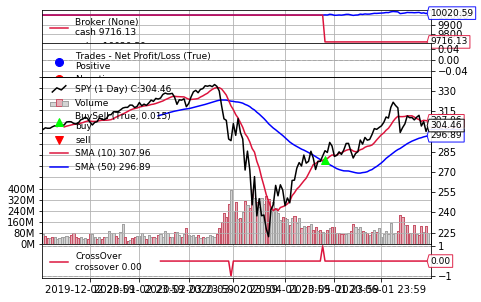

In [148]:
# SMA Cross over strategy applied for SPY

# Getting SMA CROSS strategy from backtrader
class SmaCross(bt.SignalStrategy):
    def __init__(self):
        sma1, sma2 = bt.ind.SMA(period=10), bt.ind.SMA(period=50)
        crossover = bt.ind.CrossOver(sma1, sma2)
        self.signal_add(bt.SIGNAL_LONG, crossover)

cerebro = bt.Cerebro()
cerebro.addstrategy(SmaCross)

# Fetching the required data
spy_data = bt.feeds.YahooFinanceData(dataname='SPY', fromdate=datetime(2019, 11, 1),
                                  todate=datetime(2020, 6, 30))

cerebro.adddata(spy_data)

# Runing the simulation
cerebro.run()

# Plot the result for SPY
cerebro.plot()

<IPython.core.display.Javascript object>

[[<Figure size 432x288 with 5 Axes>]]

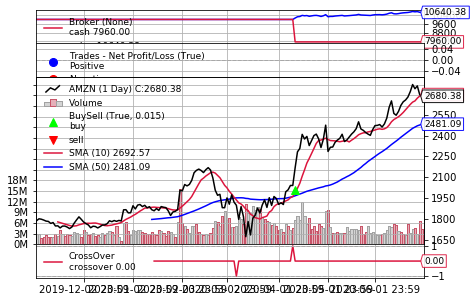

In [149]:
# SMA Cross over strategy applied for AMZN
cerebro = bt.Cerebro()
cerebro.addstrategy(SmaCross)

# Fetching the required data
amzn_data = bt.feeds.YahooFinanceData(dataname='AMZN', fromdate=datetime(2019, 11, 1),
                                  todate=datetime(2020, 6, 30))
cerebro.adddata(amzn_data)

# Runing the simulation
cerebro.run()

# Plot the result for AMZN
cerebro.plot()

<IPython.core.display.Javascript object>

[[<Figure size 432x288 with 5 Axes>]]

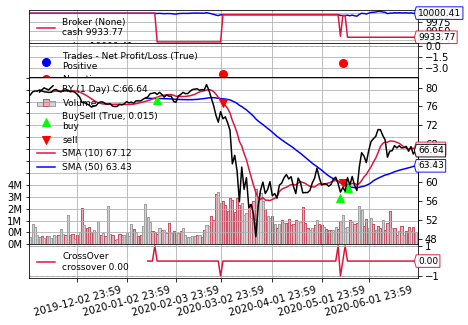

In [150]:
# SMA Cross over strategy applied for RY
cerebro = bt.Cerebro()
cerebro.addstrategy(SmaCross)

# Fetching the required data
ry_data = bt.feeds.YahooFinanceData(dataname='RY', fromdate=datetime(2019, 11, 1),
                                  todate=datetime(2020, 6, 30))
cerebro.adddata(ry_data)

# Runing the simulation
cerebro.run()

# Plot the result for RY
cerebro.plot()

<IPython.core.display.Javascript object>

[[<Figure size 432x288 with 5 Axes>]]

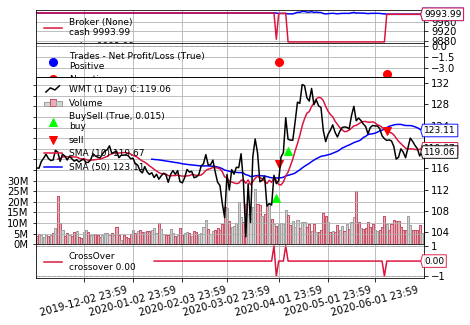

In [151]:
# SMA Cross over strategy applied for WMT
cerebro = bt.Cerebro()
cerebro.addstrategy(SmaCross)

# Fetching the required data
wmt_data = bt.feeds.YahooFinanceData(dataname='WMT', fromdate=datetime(2019, 11, 1),
                                  todate=datetime(2020, 6, 30))
cerebro.adddata(wmt_data)

# Runing the simulation
cerebro.run()

# Plot the result for WMT
cerebro.plot()